In [293]:
# reload magics
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## IMPORTS

In [294]:
import colorcet as cc
import logging
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.axes import Axes

from hdbscan import all_points_membership_vectors, HDBSCAN
from umap import UMAP

from copy import deepcopy, copy

from upsetplot import from_memberships, plot, UpSet, from_indicators

from typing import Dict, List, Tuple, Optional

palette = cc.glasbey_hv

# create a palette dictionary that has the same keys as the original palette
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')


In [295]:
# heatmap parms
heatmap_parms = {
                'cbar': False,
                'square': False,
                'linewidths': 0.5,
                'linecolor': 'black',
                'center': 0.0,
                'vmin': -1,
                'vmax': 1,
                # 'annot': False,
                'fmt': '.2f',
}

# from the data dictionary
site_name_dict = {
                  1: 'LDN',
                  2: 'MTL',
                  3: 'SAN',
                  4: 'RIO',
                  5: 'LUS',
}

# assign consistent styles
site_style = {
              1: 'D',
              2: 'o',
              3: 'P',
              4: 'X',
              5: 's',
}

In [296]:
figdir   = "./OUTPUT/lc-pos-figures"
reportdir = "../lc2-report"
data_dir = "../lc-project-data"

## FUNCTIONS

In [297]:
#===============================================================================
def compare_two_clusters(df, a, b):
#===============================================================================
# a function to compare two clusters - returns the concatenated cluster data for further analysis

    subset_a = df.query(f"cluster == {a}")
    subset_b = df.query(f"cluster == {b}")

    index_a = subset_a.index
    index_b = subset_b.index

    df_a = df.loc[index_a]
    df_b = df.loc[index_b]

    # concatenate
    df_ab = pd.concat([df_a, df_b])

    # cast cluster to int
    df_ab["cluster"] = df_ab["cluster"].astype(int)

    return df_ab


In [298]:
#===============================================================================
def make_centroids(e, lbls):
#===============================================================================

    # assume that lbls is a pandas series
    if isinstance(lbls, pd.Series):
        lbls = lbls.values
    


    # get the centroids of the umap coordinates by cluster
    centroids = pd.DataFrame(e, 
                                columns = ["x", "y"]).assign(cluster = lbls).groupby("cluster").mean()
    return centroids


#===============================================================================
def make_plot_df(embeddings, clusterer, index, sites):
#===============================================================================

    d = pd.DataFrame(embeddings, columns = ["x", "y"], index = index)
    d["Cluster"]             = clusterer.labels_
    d["Cluster Confidence"]  = clusterer.probabilities_


    try:
        d["Most Likely Cluster"] = np.argmax(all_points_membership_vectors(clusterer), axis = 1)
    except (KeyError, AttributeError):
        d["Most Likely Cluster"] = clusterer.labels_


    # EXPT

    d["Site"]                = sites


    return d



In [299]:
#===============================================================================
def plot_clusters(
                    df: pd.DataFrame, 
                    site_name_dict: dict,
                    centroids: Optional[bool] = None, 
                    # centroids: Optional[pd.DataFrame] = None, 
                    title: Optional[str] = None,
                      most_likely: bool = False,
                      size_by_prob: bool = False,
                      ax: Optional[Axes] = None,
                      ):
#===============================================================================

    # plot the embeddings
    # fig, ax = plt.subplots(figsize=(10, 10))

    if ax == None:
        fig, ax = plt.subplots(figsize=(10, 10))
    else:
        fig = None
        ax = ax
        pass


    if most_likely:
        hue = "Most Likely Cluster"
    else:
        hue = "Cluster"

    if size_by_prob:
        size = "Cluster Confidence"
    else:
        size = None

    sns.scatterplot(data = df, 
                    x = "x",
                    y = "y",
                    s = 50,
                    edgecolor = 'black', 
                    hue       = hue,
                    linewidth = 0.5, 
                    palette   = palette_dict,
                    style     = "Site",
                    style_order = site_name_dict.values(),
                    markers = ['o','D', 'P', 'X', 's'],
                    size      = size,
                    # size      = "Cluster Confidence",
                    ax = ax
                        )

    if centroids is not None:
        # plot centroids
        centroids = make_centroids(df[["x", "y"]].values, df["Cluster"])
        plot_centroids(centroids, ax)

    # set title
    if title:
        plt.title(title)

    # place the legend outside to the right of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # turn off axis labels and ticks
    if ax == None:
        plt.xticks([]); plt.yticks([]);
        plt.xlabel(""); plt.ylabel("");

        # make labels larger
        plt.tick_params(axis='both', which='major', labelsize=16)

        # make the legend larger
        plt.setp(ax.get_legend().get_texts(), fontsize='16') # for legend text
        plt.setp(ax.get_legend().get_title(), fontsize='16') # for legend title

    return fig, ax

#===============================================================================
def plot_centroids(centroids, ax, alpha = 1.0):
#===============================================================================
    # plot the centroids
    for i, centroid in centroids.iterrows():
        if i != -1:

            ax.annotate(
                        i,
                        (centroid.x, centroid.y), 
                        ha='center',
                        va='center',
                        bbox=dict(boxstyle="round,pad=0.3", 
                                    fc="white", 
                                    ec="black",
                                    lw=1, 
                                    alpha=alpha,
                                    ),
                        fontsize = 16,
                        )



In [300]:
#===============================================================================
def make_upset_data(df, 
                    ftrs, 
                    method = "mean", 
                    add_column = None,
                    keep_features = False):
#===============================================================================

    if method not in ["mean", "median"]:
        print(f"Method {method} not supported.")

    else:
        if method == "mean":
            new_df = df[ftrs] > df[ftrs].mean(axis = 0)
        # elif method == "median":
        else:
            new_df = df[ftrs] > df[ftrs].median(axis = 0)

    new_df = new_df[ftrs]
    new_df.rename(columns= {c: f">{c}" for c in ftrs}, inplace = True)

    df2 = pd.concat([df, new_df, add_column], axis = 1) # type: ignore
    if keep_features == True:
        pass
    else:
        df2 = df2.set_index(list(new_df.columns))

    return df2

In [301]:
#===============================================================================
def excursion_plot(d, 
                    method = "mean",
                    grouper = "cluster",
                    style: str = "binary",
                    figsize = (6,64),
                    ):
#===============================================================================

    norm = None

    # find all object columns and drop them
    d = d.select_dtypes(exclude = "object")

    # set the figsize to scale with the number of features
    figsize = (6, d.shape[1] / 5)

    # get the global median for each feature
    global_median = d.median()
    global_mean   = d.mean()

    globals = pd.concat([global_median, global_mean], axis = 1)
    globals.columns = ["Ensemble Median", "Ensemble Mean"]

    globals.drop(grouper, inplace = True)


    # per feature mean and median
    mm_mean   = d.groupby(grouper).mean().T
    mm_median = d.groupby(grouper).median().T

    # which version?
    if method == "mean":
        mm = mm_mean
        selector = "Ensemble Mean"
    elif method == "median":
        mm = mm_median
        selector = "Ensemble Median"
    else:
        print(f"Method {method} not supported.")
        

    if style == "cont":
        # do the basic plot of means or medians
        # colourmap
        cmap = cc.cm.bjy
        fig, ax = plt.subplots(figsize=figsize)

        # heatmsp
        sns.heatmap(mm, 
                        cmap = cmap, 
                        ax   = ax, 
                        **heatmap_parms, 
                        norm = norm, 
                        annot = True,
                        annot_kws = {"fontsize": 8}
                        )

        plt.title(f"Excursion Plot: Feature {str.title(method)} by Cluster")
        plt.yticks(fontsize = 8);
        qq = None

    else:
        # mm is the mean or median per cluster per feature
        qq = pd.DataFrame(index = mm.index, columns = mm.columns)

        # for each cluster c in mm, 
        for c in mm.columns:
            # for each feature in this cluster, compare to the respective global mean
            for i, v in enumerate(mm[c].values):
                # is this cluster's mean or median greater than 
                # the global ensemble mean or median?
                # this will fill qq with true/false
                qq.loc[qq.index[i],c] = v >  globals.loc[qq.index[i], selector] # type: ignore

        # qq.astype(int)
        fig, ax = plt.subplots(figsize=figsize)

        sns.heatmap(qq.astype(int), 
                    cmap = cc.bjy, 
                    ax = ax, 
                    cbar = False, 
                    vmin = -1, 
                    linewidth = 0.5, 
                    square = False, 
                    linecolor = 'k'
                    )

        plt.yticks(fontsize = 8);
        plt.title(f"Excursion Plot: {str.title(grouper)} {str.title(method)} > {selector}")

    return globals, qq

In [302]:
#===============================================================================
def plot_cluster_by_site(src,
                         data,
                         labels,
                        site_name_dict: dict,

                         title: str,
                         tag: str,
                         ):
#===============================================================================

    # make a copy of the source data
    site_g = src.copy()

    # augment with cluster labels
    site_g.loc[data.index, "cluster"] = labels["Cluster"]

    # group and count
    cluster_by_site = site_g.groupby("cluster")["SITE"].value_counts().unstack().T

    # fill missing values
    cluster_by_site = cluster_by_site.fillna(0).astype(int)

    # map SITE values using site-name_dict

    cluster_by_site.index = cluster_by_site.index.map(site_name_dict)



    # rename columns
    cluster_by_site.columns = cluster_by_site.columns.astype(int)
    # cluster_by_site = cluster_by_site.loc[site_name_dict.values()]

    # sort index alphabetically
    

    fig, ax = plt.subplots(figsize=(8,8), layout = "constrained")

    sns.heatmap(cluster_by_site, 
                robust     = True, 
                ax         = ax, 
                annot      = True, 
                fmt        = "d", 
                cmap       = "viridis", 
                square     = True, 
                linewidths = 0.5, 
                linecolor  = "w", 
                cbar       = False)

    # rename axis labels
    plt.xlabel("Cluster")
    plt.ylabel("Site")
    plt.title(title)

    # fn = f"cluster-membership-umap-{tag}.png"
    # p = f"{figdir}/{fn}"

    # plt.savefig(p, dpi = 300, bbox_inches = 'tight')


## LOAD DATA

In [303]:
# load the data from the xlsx file
# df = pd.read_excel('../lc-project-data/features.xlsx')

In [363]:
# datasets are way faster than excel files
from datasets.arrow_dataset import Dataset

# get today's date

import datetime
today = datetime.date.today().strftime("%Y-%m-%d")

# today = "2024-04-30"


# load the dataset from disk
ds_all = Dataset.load_from_disk(f'../lc-project-data/{today}-features.arrow')
ds     = Dataset.load_from_disk(f'../lc-project-data/{today}-features.arrow')
# ds_all = Dataset.load_from_disk('../lc-project-data/features.arrow')
# ds     = Dataset.load_from_disk('../lc-project-data/features.arrow')

In [364]:
df_all = ds_all.data.to_pandas()
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Columns: 449 entries, sex to __index_level_0__
dtypes: bool(4), float64(389), int64(55), object(1)
memory usage: 19.3+ MB


In [365]:
# convert to pandas dataframe
df = ds.to_pandas()
df.info() # type: ignore

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Columns: 449 entries, sex to __index_level_0__
dtypes: bool(4), float64(389), int64(55), object(1)
memory usage: 19.3+ MB


In [366]:
# drop __index_level_0__
df = df.drop(columns = ["__index_level_0__"])

## LC+, LC-, HC

### Select which sets of feaetures to use

In [367]:
tag = 'all'

print(df.shape) # type: ignore

(5664, 448)


In [368]:
LC_pos = df.query('LC_STATUS == "LC_POS"').copy() # type: ignore
LC_neg = df.query('LC_STATUS == "LC_NEG"').copy() # type: ignore 
HC     = df.query('LC_STATUS == "HC"').copy()     # type: ignore

In [369]:
# LC_pos["CD-severity_level___3"]
# # make a heatmap of all of the CD-severity levels
# fig, ax = plt.subplots(figsize=(8,8))

# sns.heatmap(LC_pos[["CD-severity_level___0", "CD-severity_level___1", "CD-severity_level___2", "CD-severity_level___3"]],)
# # severity level is accoerding to PCR
# # what about sites that didn't use PCR? are they all zero by default?
# LC_pos["CD-mode_of_diag"].value_counts()
# sns.heatmap(LC_pos[["CD-mode_of_diag"]])

In [370]:
LC_pos.shape, LC_neg.shape, HC.shape

((2214, 448), (3367, 448), (83, 448))

In [371]:
# drop object columns because we don't need this 
try:
    LC_pos = LC_pos.drop(columns=['LC_STATUS'])
except:
    pass

# drop __index



In [372]:
LC_pos

sex   age  SITE  MED-Analgesics  MED-Anesthetics  MED-Antibacterials  \
0     2.0  30.0     2               0                0                   0   
1     1.0  33.0     2               0                0                   0   
2     2.0  36.0     2               0                0                   0   
3     2.0  50.0     2               0                0                   0   
4     1.0  40.0     2               0                0                   0   
...   ...   ...   ...             ...              ...                 ...   
5659  1.0  48.0     3               0                0                   0   
5660  2.0  42.0     3               0                0                   0   
5661  1.0  23.0     3               0                0                   0   
5662  1.0  71.0     3               0                0                   0   
5663  2.0  58.0     3               0                0                   0   

      MED-Anticonvulsants  MED-Antidepressants  MED-Antifungals  \
0                       0                    0                0   
1                       0                    0                0   
2                       0                    0                0   
3                       0                    0                0   
4                       0                    0                0   
...                   ...                  ...              ...   
5659                    0                    0                0   
5660                    0                    0                0   
5661                    0                    0                0   
5662                    0                    0                0   
5663                    0                    0                0   

      MED-Antimigraine-agents  ...  LABS-IND-troponinihigh  \
0                           0  ...                     0.0   
1                           0  ...                     0.0   
2                           0  ...                     0.0   
3                           0  ...                     0.0   
4                           0  ...                     0.0   
...                       ...  ...                     ...   
5659                        0  ...                     0.0   
5660                        0  ...                     0.0   
5661                        0  ...                     0.0   
5662                        0  ...                     0.0   
5663                        0  ...                     0.0   

      LABS-IND-troponint  LABS-IND-troponinthigh  LABS-IND-urea  LABS-IND-wbc  \
0                    0.0                     0.0            0.0           0.0   
1                    0.0                     0.0            0.0           0.0   
2                    0.0                     0.0            0.0           0.0   
3                    0.0                     0.0            0.0           0.0   
4                    0.0                     0.0            0.0           0.0   
...                  ...                     ...            ...           ...   
5659                 0.0                     0.0            1.0           0.0   
5660                 0.0                     0.0            1.0           1.0   
5661                 0.0                     0.0            0.0           0.0   
5662                 0.0                     0.0            1.0           0.0   
5663                 0.0                     0.0            1.0           1.0   

      SUBST-1  SUBST-2  SUBST-3  SUBST-4  SUBST-5  
0         0.0      0.0      0.0      0.0      0.0  
1         0.0      0.0      0.0      0.0      0.0  
2         0.0      0.0      0.0      0.0      0.0  
3         1.0      0.0      0.0      0.0      0.0  
4         0.0      0.0      0.0      0.0      0.0  
...       ...      ...      ...      ...      ...  
5659      0.0      0.0      1.0      0.0      0.0  
5660      0.0      0.0      0.0      0.0      0.0  
5661      0.0      0.0      1.0      1.0      0.0  
5662      0.0      0.0    

In [373]:
# # how many missing values per dag?
# print("Missing VAX values by site:")
# LC_pos.groupby('SITE').apply(lambda x: x.isnull().sum()).rename(index = site_name_dict)["VAX-vaccinated"]
# # drop rows where VAX-vaccinated is nan
# LC_pos = LC_pos.dropna(subset = ["VAX-vaccinated"])

# print(LC_pos.shape)

In [374]:
# # how many Nans in LC_pos?
# LC_pos.isnull().sum()

## SITES

In [375]:
# # get the range of indices for each site
# site_ranges = LC_pos.groupby('SITE').apply(lambda x: (x.index.min(), x.index.max())).rename(index = site_name_dict) # type: ignore

# site_ranges
# # site_ranges.sort_values()

### Drop Sites

In [376]:
# drop RIO and LUS
# LC_pos = LC_pos.query('SITE != "RIO" and SITE != "LUS"')
# LC_pos = LC_pos.query('SITE != "LUS"')
LC_pos['SITE'].value_counts()

SITE
2    915
4    651
5    272
3    266
1    110
Name: count, dtype: int64

# CLUSTERING

In [377]:
# clustering
from sklearn.preprocessing import MinMaxScaler

# dim reduction and clustering benefit from scaling
scaler = MinMaxScaler().set_output(transform = "pandas")

### Which features to drop, if any

In [378]:
# a new dataframe, in case we need to manipulate it and retain the original
LC_pos_ = LC_pos.copy()

# drop certain columns, to experiment with effect on clustering

# drop columns that relate to non-covid events
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '___3').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '___4').columns)
# the foregoing drops medication_received___3 and medication_received___4
# we need to restore them
LC_pos_["CD-medication_received___3"] = LC_pos["CD-medication_received___3"]
LC_pos_["CD-medication_received___4"] = LC_pos["CD-medication_received___4"]
LC_pos_["CD-ventilatory_support_type___3"] = LC_pos["CD-ventilatory_support_type___3"]
LC_pos_["CD-ventilatory_support_type___4"] = LC_pos["CD-ventilatory_support_type___4"]

LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '-3').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '-4').columns)

# drop specific columns
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-severity_level').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-mode_of').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-type_of').columns)

# drop medications and substances
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'MED-').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'SUBST-').columns)

# find all column names that start with SYMPT and end with ___1
# these are for the initial covid infection
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'SYMPT.*___1').columns)

# drop all HHX
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'HHX').columns)

# drop all VAX
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'VAX').columns)

# drop all CD-covid_test_result
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-covid_test_result').columns)

# drop all LABS-IND*
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'LABS-IND').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'IMG').columns)

# drop all CD-
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-').columns)

vitals = ['temperature',
'heart_rate',
'bp_systolic',
'bp_diastolic',
'respiratory_rate',
'o2_saturation',]

# remove any features that contain words inthe vitals list
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '|'.join(vitals)).columns)


print(LC_pos_.shape)

(2214, 246)


In [379]:
LC_pos_.columns

Index(['sex', 'age', 'SITE', 'MED-Analgesics', 'MED-Anesthetics',
       'MED-Antibacterials', 'MED-Anticonvulsants', 'MED-Antidepressants',
       'MED-Antifungals', 'MED-Antimigraine-agents',
       ...
       'LAB-test-spirometry', 'LAB-test-lung_function', 'LAB-test-metacholine',
       'SUBST-1', 'SUBST-2', 'SUBST-5', 'CD-medication_received___3',
       'CD-medication_received___4', 'CD-ventilatory_support_type___3',
       'CD-ventilatory_support_type___4'],
      dtype='object', length=246)

In [380]:
for c in LC_pos_.columns:
    print(c)

sex
age
SITE
MED-Analgesics
MED-Anesthetics
MED-Antibacterials
MED-Anticonvulsants
MED-Antidepressants
MED-Antifungals
MED-Antimigraine-agents
MED-Antiparasitics
MED-Antiparkinson-agents
MED-Antipsychotics
MED-Antispasticity-agents
MED-Antivirals
MED-Blood-glucose-regulators
MED-Blood-products
MED-Cardiovascular-agents
MED-Dental-and-oral-agents
MED-Dermatological-agents
MED-Gastrointestinal-agents
MED-Hormonal-agents-(adrenal)
MED-Hormonal-agents-(sex-hormones)
MED-Hormonal-agents-(thyroid)
MED-Hormone-suppressant-(thyroid)
MED-Immunological-agents
MED-Inflammatory-bowel-disease-agents
MED-Metabolic-bone-disease-agents
MED-Ophthalmic-agents
MED-Respiratory-tract-agents
MED-Skeletal-muscle-relaxants
SYMPT-abdominal_pain___2
SYMPT-chest_pain___2
SYMPT-confusion_altered_mental_s___2
SYMPT-cough___2
SYMPT-diarrhea___2
SYMPT-dizziness___2
SYMPT-ear_pain___2
SYMPT-extremity_weakness_or_numb___2
SYMPT-fatigue___2
SYMPT-fever_38_0oc___2
SYMPT-headache___2
SYMPT-hemoptysis_bloody_sputum___2
SY

In [381]:
# drop the dag and SITE columns - these might guide the clustering algorithm to cluster by site

try:
    LC_pos_ = LC_pos_.drop(columns=['LC_STATUS'])
except:
    pass

# always drop the SITE!
X = scaler.fit_transform(LC_pos_.drop(columns=['SITE']))     # type: ignore


# sort X randomly
# X = X.sample(frac = 1)

## Use UMAP to visualize the data and cluster

In [382]:
from hdbscan import HDBSCAN, approximate_predict, all_points_membership_vectors
from umap import UMAP

hdb_parms = {
                # min_cluster_size is rouglhy 
                # sqrt(n) where n is the number of samples
                'min_cluster_size': 50, 
                # 'min_samples': 50,
                'prediction_data': True,
                'cluster_selection_method': 'leaf',
                'cluster_selection_epsilon': 0.1,
            }


umap_parms = {
                'n_components': 2,
                'spread':       5.0,
                'random_state': 42,
            }


# instantiate the clustering and dim reduction objects
hdb_umap   = HDBSCAN(**hdb_parms)
umap_      = UMAP(**umap_parms)

### Handling missing values

In [383]:
# the clustering algorithms depend on the data being complete

# X.dropna(inplace = True, axis = 1)

# drop rows that have a nan in any column
X.dropna(inplace = True, axis = 0)

# if we fill with zeroes, then we are assuming that the missing values are zero
# X.fillna(0, inplace = True)

print(X.shape)


(2209, 245)


### EMBED and CLUSTER

In [384]:
# EXPERIMENTAL
# drop rows in X that are referenced by list in idx

# X = X.drop(index = idx)

In [385]:
X.shape

(2209, 245)

In [386]:
# sklearn pipelines
import sklearn.cluster as cluster
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

from hdbscan import HDBSCAN



min_cluster_size = int(np.sqrt(X.shape[0]))

hdb_parms = {
                # min_cluster_size is roughly 
                # sqrt(n) where n is the number of samples
                'min_cluster_size': min_cluster_size, 
                'cluster_selection_method': 'leaf',
                'cluster_selection_epsilon': 0.1,
                # 'cluster_selection_epsilon': 0.5,
            }

umap_parms = {
                'n_components': 2,
                'spread':       2.0,
                'random_state': 42,
            }


tsne_transformer = FunctionTransformer(TSNE(n_components = 2, 
                                            random_state = 42, 
                                            verbose = 1).fit_transform, validate=False)

umap_transformer = UMAP(**umap_parms, verbose = True)

embedding_model = umap_transformer
# embedding_model = tsne_transformer

# instantiate the pipeline
pipe = Pipeline([
                # scale to unit size
                ('scaler', MinMaxScaler()),
                # for embeddings, we can use TSNE or UMAP
                ('embed', embedding_model),
                # the sklearn HDBCSAN implementation does not have all the 
                # methods of the hdbscan package, so we need to use the hdbscan package
                ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),
                ])

# apply to the feature dataframe
pipe.fit(X)

if isinstance(pipe.steps[1][1], UMAP):
    points   = pipe["embed"].embedding_
elif isinstance(pipe.steps[1][1], FunctionTransformer):
    points   = pipe["embed"].transform(X)
else:
    print(f"Something went wrong - {pipe.steps[1][1]}")


clusters = pipe["cluster"].labels_
probs    = pipe["cluster"].probabilities_
sites    = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)

# # cluster labels are the maximally probable cluster
cluster_labels = np.argmax(all_points_membership_vectors(pipe["cluster"]), 
                           axis = 1)

clusters = cluster_labels

/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(random_state=42, spread=2.0, verbose=True)
Fri May  3 08:18:41 2024 Construct fuzzy simplicial set
Fri May  3 08:18:42 2024 Finding Nearest Neighbors
Fri May  3 08:18:42 2024 Finished Nearest Neighbor Search
Fri May  3 08:18:42 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri May  3 08:18:45 2024 Finished embedding


In [387]:
plot_df = pd.DataFrame(points, columns = ["x", "y"], index = X.index)
plot_df["Cluster"]            = clusters
plot_df["Cluster Confidence"] = probs
plot_df["Site"]               = sites

# what fraction of the data is in each cluster?
plot_df["Cluster"].value_counts(normalize = True)*100


Cluster
5    24.173834
4    20.099593
3    17.021277
6    13.263920
0    10.004527
2     9.732911
1     5.703938
Name: proportion, dtype: float64

<Axes: xlabel='x', ylabel='y'>

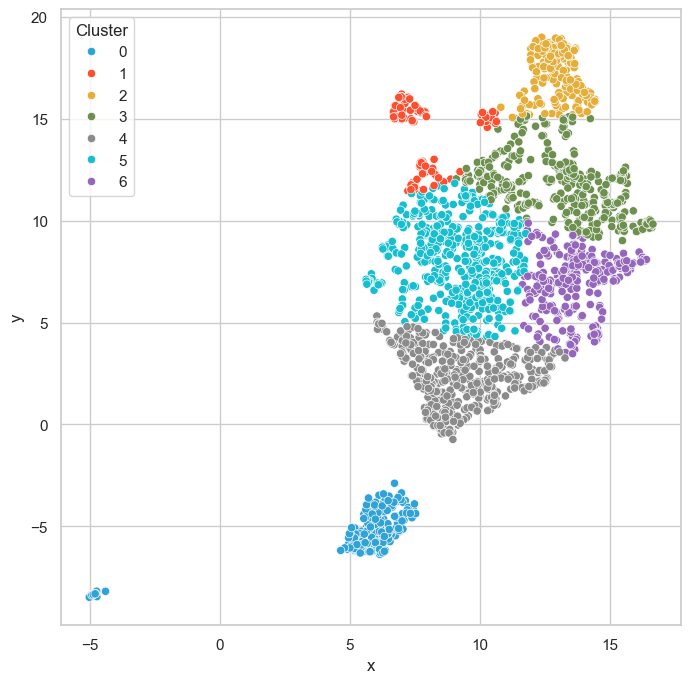

In [388]:
sns.scatterplot(x = plot_df["x"], y = plot_df["y"], hue = plot_df["Cluster"], palette = palette_dict)

In [391]:
# X.loc[145].filter(regex = 'SYMPT')
# LC_pos_.loc[145].filter(regex = 'SYMPT')
# # which points have X > 20?
# plot_df.query("x > 20")

# get the indices
idx = plot_df.query("x < 0").index
idx

Index([ 155,  192,  781,  905,  912,  917,  922,  929,  931,  986, 1000, 1030,
       1058, 1083, 1102, 1103, 1104, 1106, 1107, 1138, 5651],
      dtype='int64')

In [392]:
# # read the records from "LC_POSITIVE_RECORD_IDS.csv"

# record_ids = pd.read_csv(f"{data_dir}/LC_POSITIVE_RECORD_IDS.csv", header = 0, index_col = 0)

# record_ids

# get the patient record_id that corresponds to idx
# record_ids.loc[idx]["record_id"].to_list()
# sns.heatmap(X.loc[idx].filter(regex = 'SYMPT').T, **heatmap_parms
# sns.heatmap(X.sample(20).filter(regex = 'SYMPT').T, **heatmap_parms)

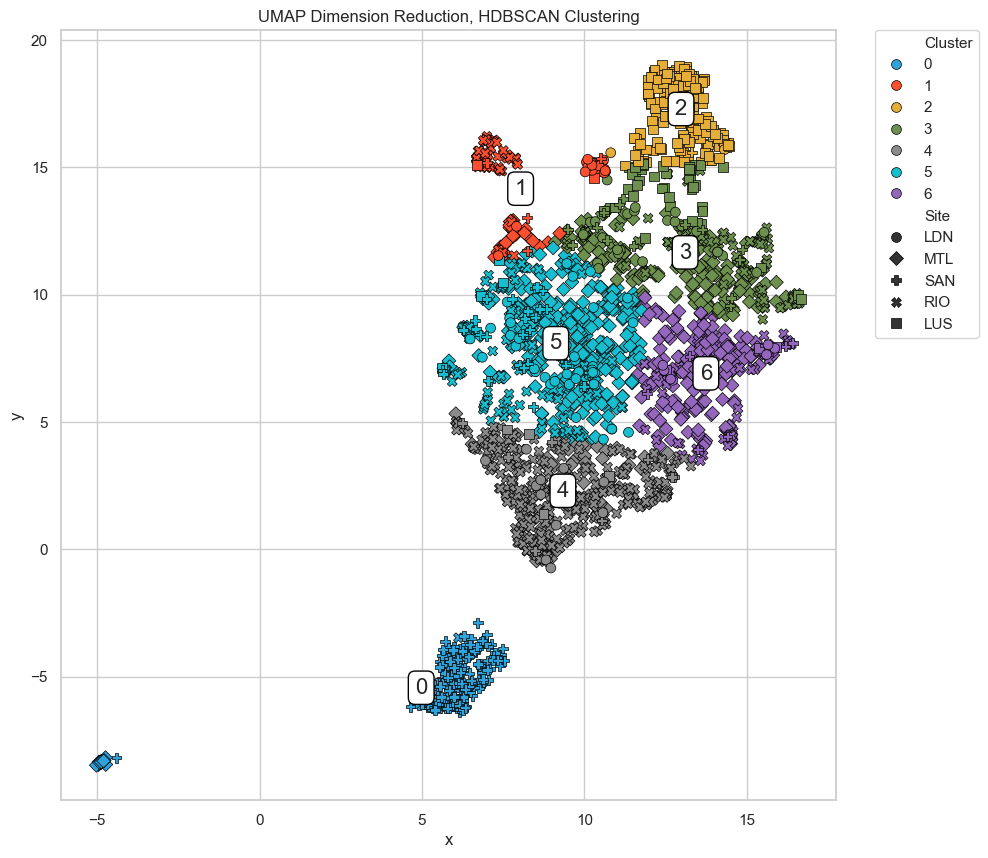

In [393]:
fig_umap, ax_umap = plot_clusters(plot_df, site_name_dict, title = f"UMAP Dimension Reduction, HDBSCAN Clustering", centroids = True, size_by_prob = False, ax = None)

plt.savefig(f"{figdir}/tsne-hdbscan-umap.png", dpi = 300, bbox_inches = 'tight')

#### Cluster by Site

In [394]:
# count cluster members by site
cluster_by_site = plot_df.groupby("Cluster")["Site"].value_counts().unstack().T.fillna(0).astype(int)

# convert to percent of site
# cluster_by_site = cluster_by_site.div(cluster_by_site.sum(axis = 1), axis = 0)*100

print(cluster_by_site)

# output cluster_by_site to latex
cluster_by_site.to_latex(f"{reportdir}/cluster-by-site.tex")


# plot_cluster_by_site(LC_pos_, X, plot_df, site_name_dict, "HDBSCAN Clustering", tag)

# plt.savefig(f"{figdir}/cluster-membership-tsne-hdbscan.png", dpi = 300, bbox_inches = 'tight')

Cluster    0   1    2    3    4    5    6
Site                                     
LDN        2  23    2   26   12   38    7
LUS        0   4  212   41    4    4    3
MTL       20  39    0  189   82  357  228
RIO        1  56    0  105  337  103   48
SAN      198   4    1   15    9   32    7


#### RFC Model to identify features that differentiate clusters

In [395]:
# use a random forest classifier to find the most important features
from sklearn.ensemble import RandomForestClassifier

# use xgboost
# from xgboost import XGBClassifier
# clf = XGBClassifier(n_estimators = 100, max_depth = 1, random_state = 42)


# instantiate the classifier
# clf = RandomForestClassifier(n_estimators = 1_000, max_depth = 11, random_state = 42)

# use all cores
clf = RandomForestClassifier(n_jobs=-1, 
                            #  n_estimators = 100, 
                            #  class_weight='balanced', 
                             max_depth=7
                             )

# fit the classifier
clf.fit(X, cluster_labels)

# get the 20 most important features
importances = clf.feature_importances_
indices     = np.argsort(importances)[::-1][:20]
features    = X.columns

In [396]:
from boruta_py.boruta import BorutaPy

# instantiate the Boruta feature selector

boruta = BorutaPy(clf, 
                #   n_estimators = 1_000, 
                  n_estimators = 'auto',
                  verbose      = 1, 
                  random_state = 42, 
                  perc         = 100
                  )
boruta.fit(X, cluster_labels)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100


BorutaPy finished running.

Iteration: 	35 / 100
Confirmed: 	34
Tentative: 	0
Rejected: 	211


BorutaPy(estimator=RandomForestClassifier(max_depth=7, n_estimators=121,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x317A85740),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x317A85740,
         verbose=1)

In [397]:
# make a subset of the data with the important features and 
# fit a classifier on it, using the cluster labels as the target
important_features = X.columns[boruta.support_]
clf.fit(X[important_features], cluster_labels)

# # show the probas predicted by the trained model
# qq = clf.predict_proba(X[important_features])
# sns.heatmap(qq, cmap = "viridis",)

RandomForestClassifier(max_depth=7, n_estimators=121, n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x317A85740)

In [398]:
boruta.ranking_

fff = pd.DataFrame({"Feature": X.columns, "Ranking": boruta.ranking_, "Importance":boruta.support_, })
fff

Feature  Ranking  Importance
0                                sex        1        True
1                                age        1        True
2                     MED-Analgesics       22       False
3                    MED-Anesthetics      134       False
4                 MED-Antibacterials       54       False
..                               ...      ...         ...
240                          SUBST-5       74       False
241       CD-medication_received___3        1        True
242       CD-medication_received___4        1        True
243  CD-ventilatory_support_type___3      178       False
244  CD-ventilatory_support_type___4       63       False

[245 rows x 3 columns]

In [399]:
# # write lambda function to get the numeric value of the feature importance if Importance is true, or zero otherwise
# get_importance = lambda x: x if x else 0

# # apply the lambda function to the "Importance" column
# fff["FI"] = fff["Importance"].apply(get_importance)

In [400]:
for i, f in fff.iterrows():
    if f["Importance"] == True:
        fff.loc[i, "FI"] = importances[i]
    else:
        fff.loc[i, "FI"] = 0

fff.sort_values(by = "FI", ascending = False, inplace = True)
fff

Feature  Ranking  Importance        FI
38                      SYMPT-fatigue___2        1        True  0.074620
37   SYMPT-extremity_weakness_or_numb___2        1        True  0.072602
42        SYMPT-joint_pain_arthralgia___2        1        True  0.067675
46         SYMPT-muscle_aches_myalgia___2        1        True  0.061439
227                   CD-type_of_care___2        1        True  0.059456
..                                    ...      ...         ...       ...
99                           HHX-OTHER-OB      106       False  0.000000
100              HHX-OTHER-Sleep-disorder       11       False  0.000000
101                 HHX-OTHER-UNSPECIFIED      178       False  0.000000
102                      HHX-OTHER-chagas      178       False  0.000000
244       CD-ventilatory_support_type___4       63       False  0.000000

[245 rows x 4 columns]

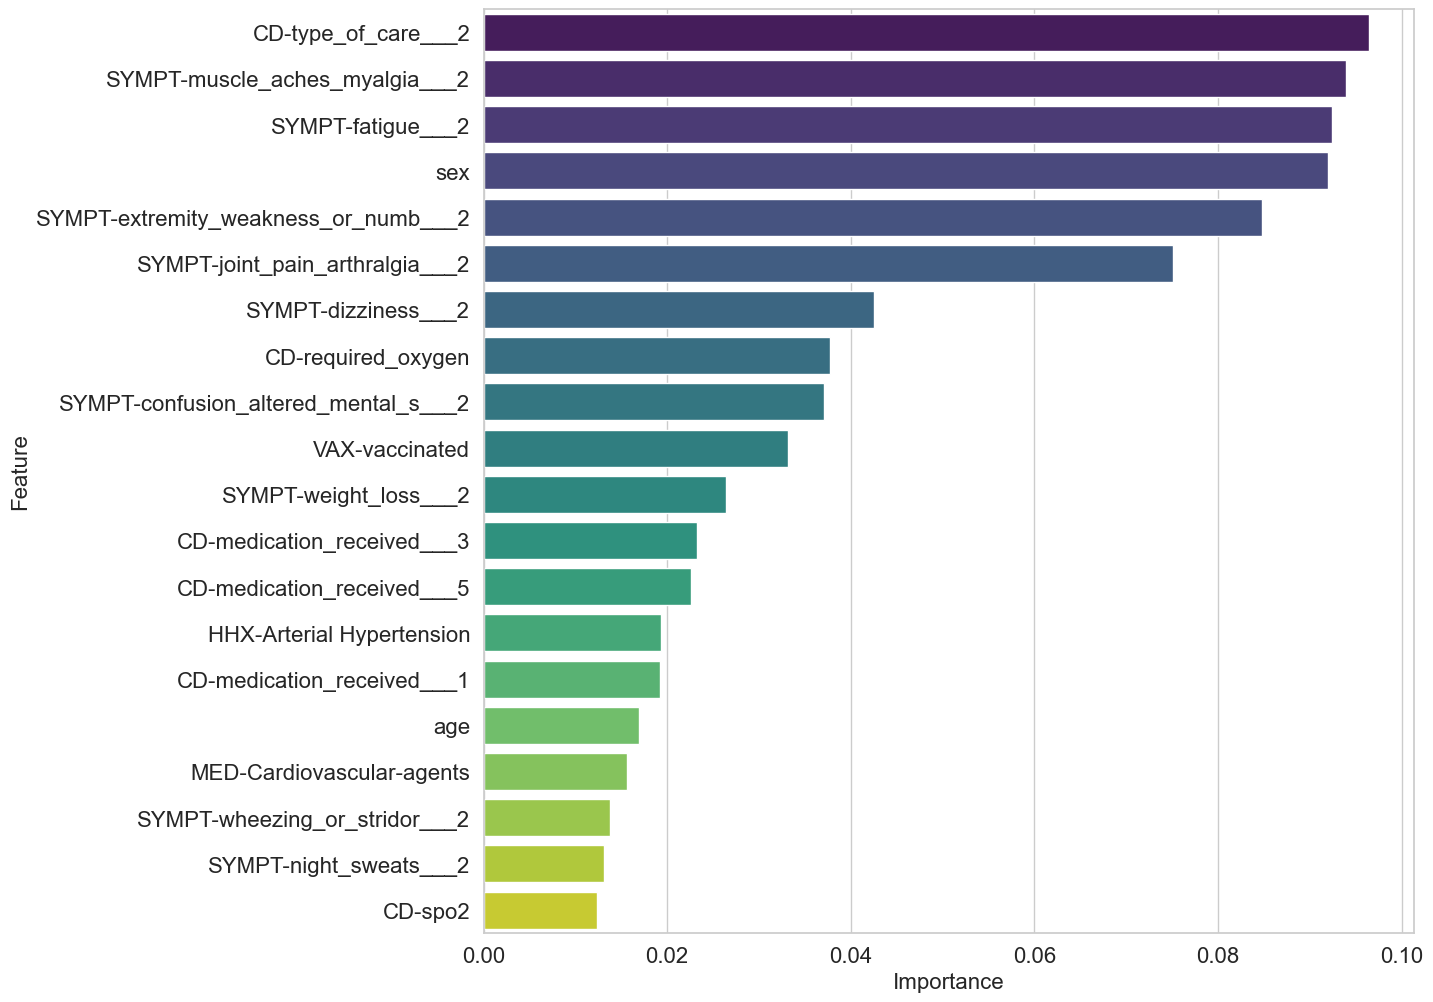

In [401]:
# make a dataframe of the important features
dd = pd.DataFrame(clf.feature_importances_, 
                  index = important_features, 
                  columns = ["Importance"]).sort_values("Importance", ascending = False)

dd.reset_index(inplace = True)
dd.rename(columns = {"index": "Feature"}, inplace = True)

features20 = dd[:20]

fig2, axbar = plt.subplots(figsize=(12,12))

# plt.title("Feature importances driving Clustering")

sns.barplot(
                y       = features20["Feature"], 
                x       = features20["Importance"],
                palette = "viridis", 
                hue     = features20["Feature"],
                # orient = "h",
                ax = axbar
                )

# make ticks larger
plt.tick_params(axis='both', which='major', labelsize=16)
# make axis labels larger
plt.xlabel("Importance", fontsize = 16)
plt.ylabel("Feature", fontsize = 16)


# rotate 90 degrees
# plt.xticks(rotation=90)

plt.savefig(f"{figdir}/feature-importances.png", dpi = 300, bbox_inches = 'tight')

In [402]:
# make a dataframe of the important features
dd = pd.DataFrame(clf.feature_importances_, 
                  index = important_features, 
                  columns = ["Importance"]).sort_values("Importance", ascending = False)

dd.reset_index(inplace = True)
dd.rename(columns = {"index": "Feature"}, inplace = True)

features20 = dd[:20].copy()


# rename the features in features20:
features20["Feature"] = features20["Feature"].str.replace("CD-type_of_care___2", "Care: Non-ICU")

# medication received
features20["Feature"] = features20["Feature"].str.replace("CD-medication_received___1", "Rx: Steroids")
features20["Feature"] = features20["Feature"].str.replace("CD-medication_received___2", "Rx: Remdesivir")
features20["Feature"] = features20["Feature"].str.replace("CD-medication_received___3", "Rx: Anticoagulant")
features20["Feature"] = features20["Feature"].str.replace("CD-medication_received___4", "Rx: Colchicine")
features20["Feature"] = features20["Feature"].str.replace("CD-medication_received___5", "Rx: Antibiotics")



# rename the features in features20:
features20["Feature"] = features20["Feature"].str.replace("CD-", "")
features20["Feature"] = features20["Feature"].str.replace("SYMPT-", "").str.split("___").str[0]

# type of care
features20["Feature"] = features20["Feature"].str.replace("fever_38_0oc", "Fever > 38.0 °C")

# replace underscores with spaces
features20["Feature"] = features20["Feature"].str.replace("_", " ")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Feature')

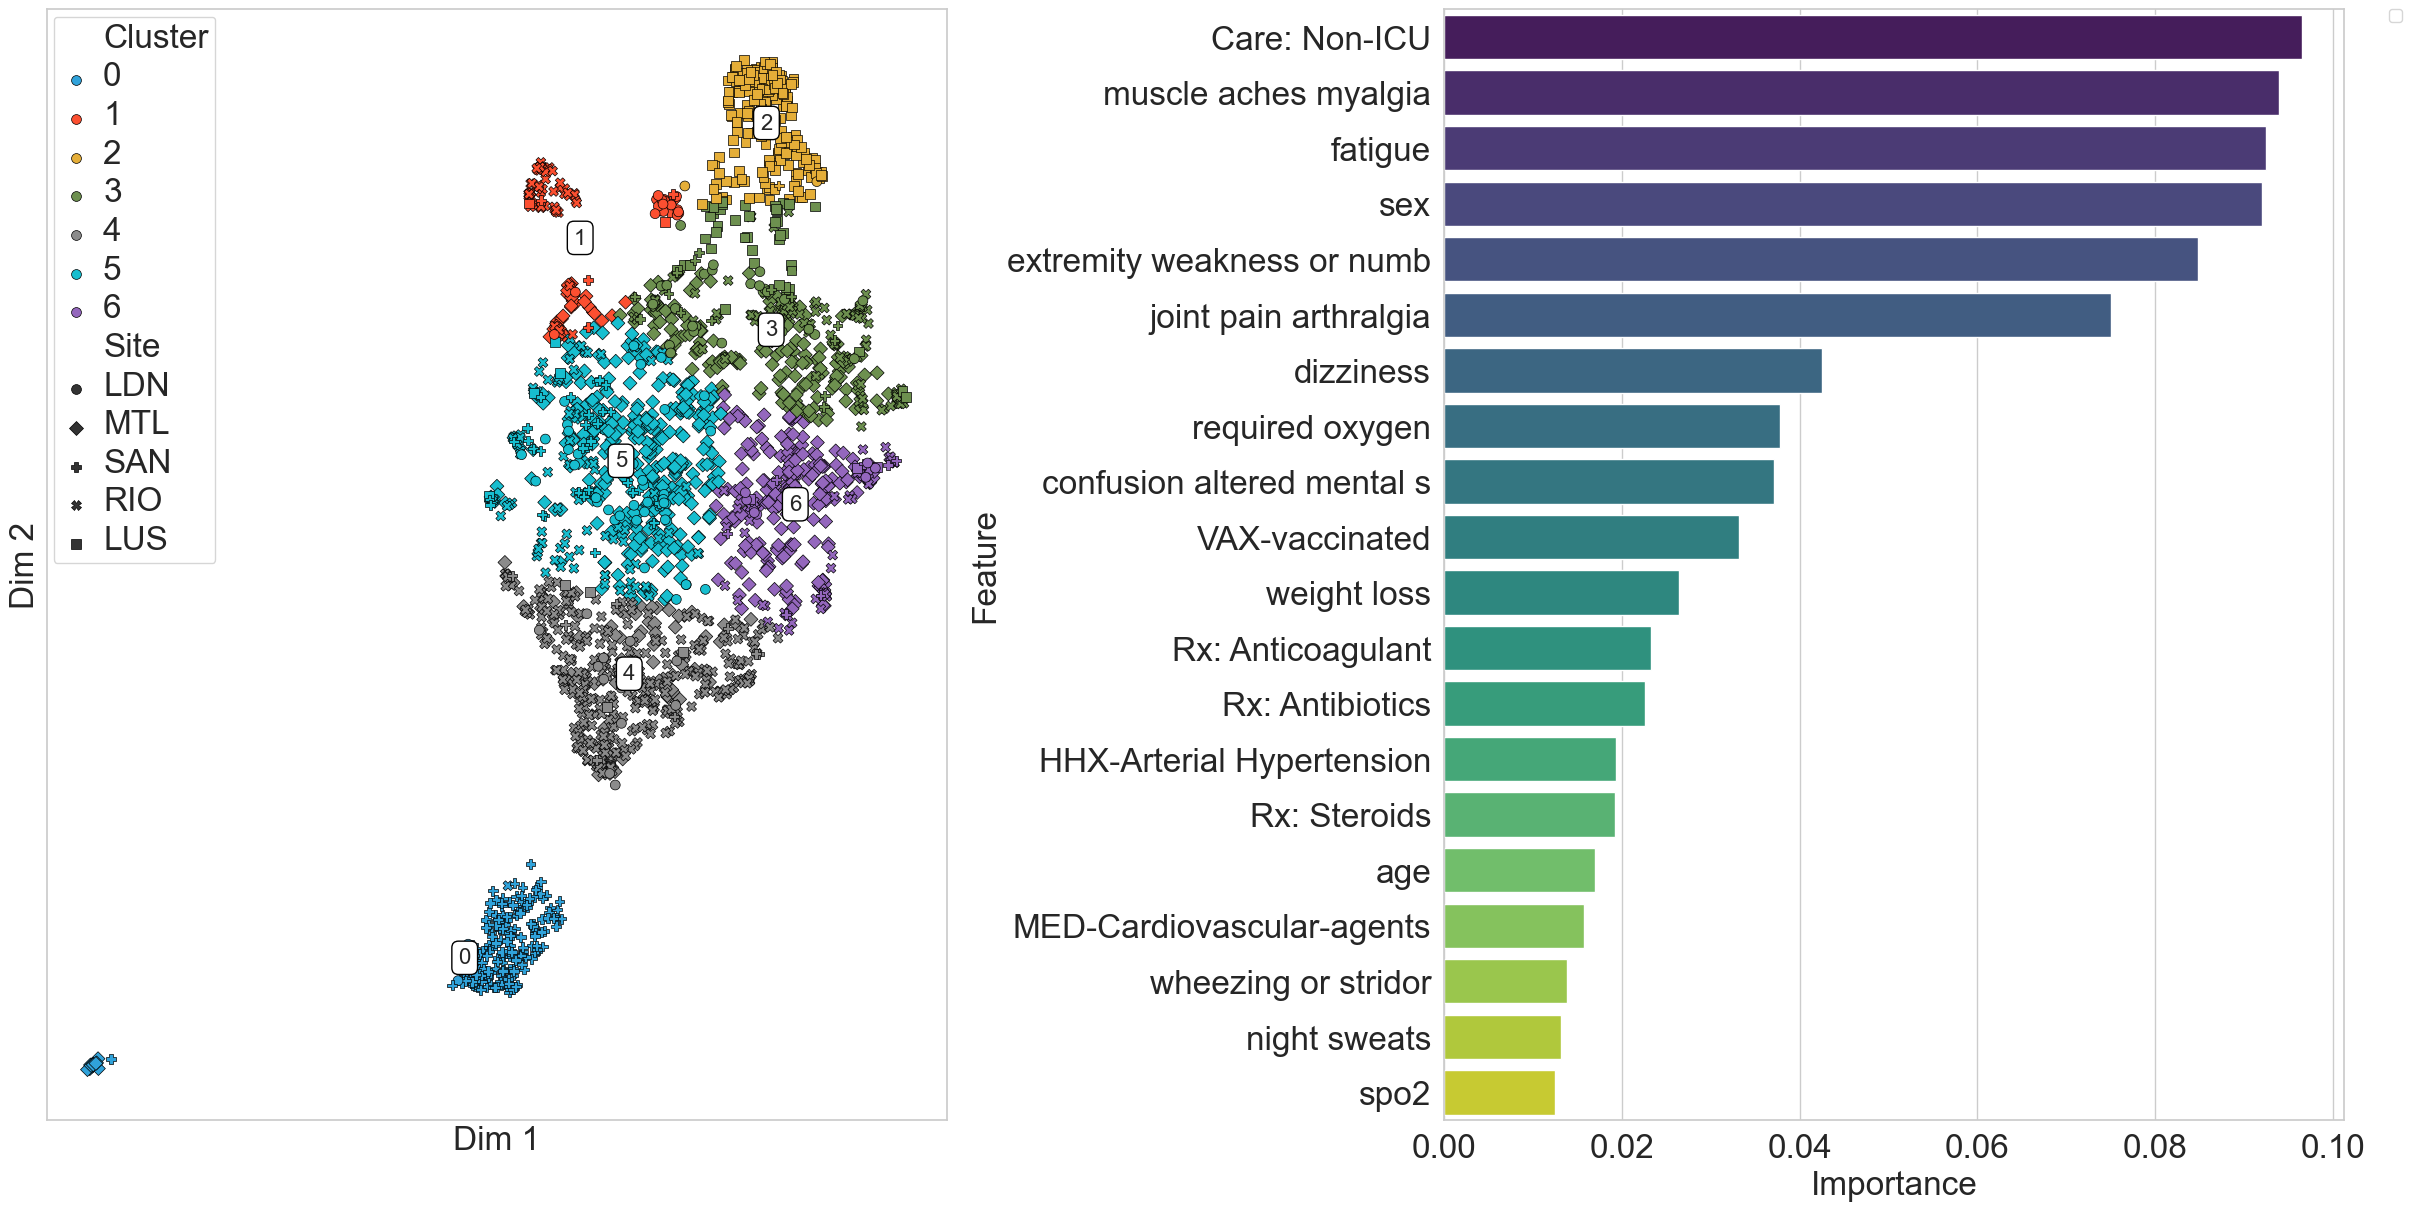

In [403]:

# make a 2x1 plot
fig_2up, ax = plt.subplots(1,2, figsize=(24,12), layout = "constrained")

FONTSIZE = 24

# first, plot the umap clusters
plot_clusters(plot_df, site_name_dict, title = None, centroids = True, size_by_prob = False, ax = ax[0])

# second, plot the feature importances
sns.barplot(
                y       = features20["Feature"], 
                x       = features20["Importance"],
                palette = "viridis", 
                hue     = features20["Feature"],
                # orient = "h",
                ax = ax[1]
                )


# on the umap plot, ax[0]
# turn off axis labels and ticks on ax[0]
ax[0].set_xticks([]); ax[0].set_yticks([]);
ax[0].set_xlabel("Dim 1", fontsize = FONTSIZE); 
ax[0].set_ylabel("Dim 2", fontsize = FONTSIZE);
# set the legend larger in ax[0]
plt.setp(ax[0].get_legend().get_texts(), fontsize=FONTSIZE) # for legend text
# scale up the markers in ax[0] legend

# on the bar plot, ax[1]
# make the x ticks and label larger
ax[1].tick_params(axis='both', which='major', labelsize=FONTSIZE)
ax[1].set_xlabel("Importance", fontsize = FONTSIZE)
ax[1].set_ylabel("Feature", fontsize = FONTSIZE)



# plt.savefig(f"{figdir}/feature-importances.png", dpi = 300, bbox_inches = 'tight')

In [404]:
sympt_dict = {0:"Absent", 1:"Present"}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

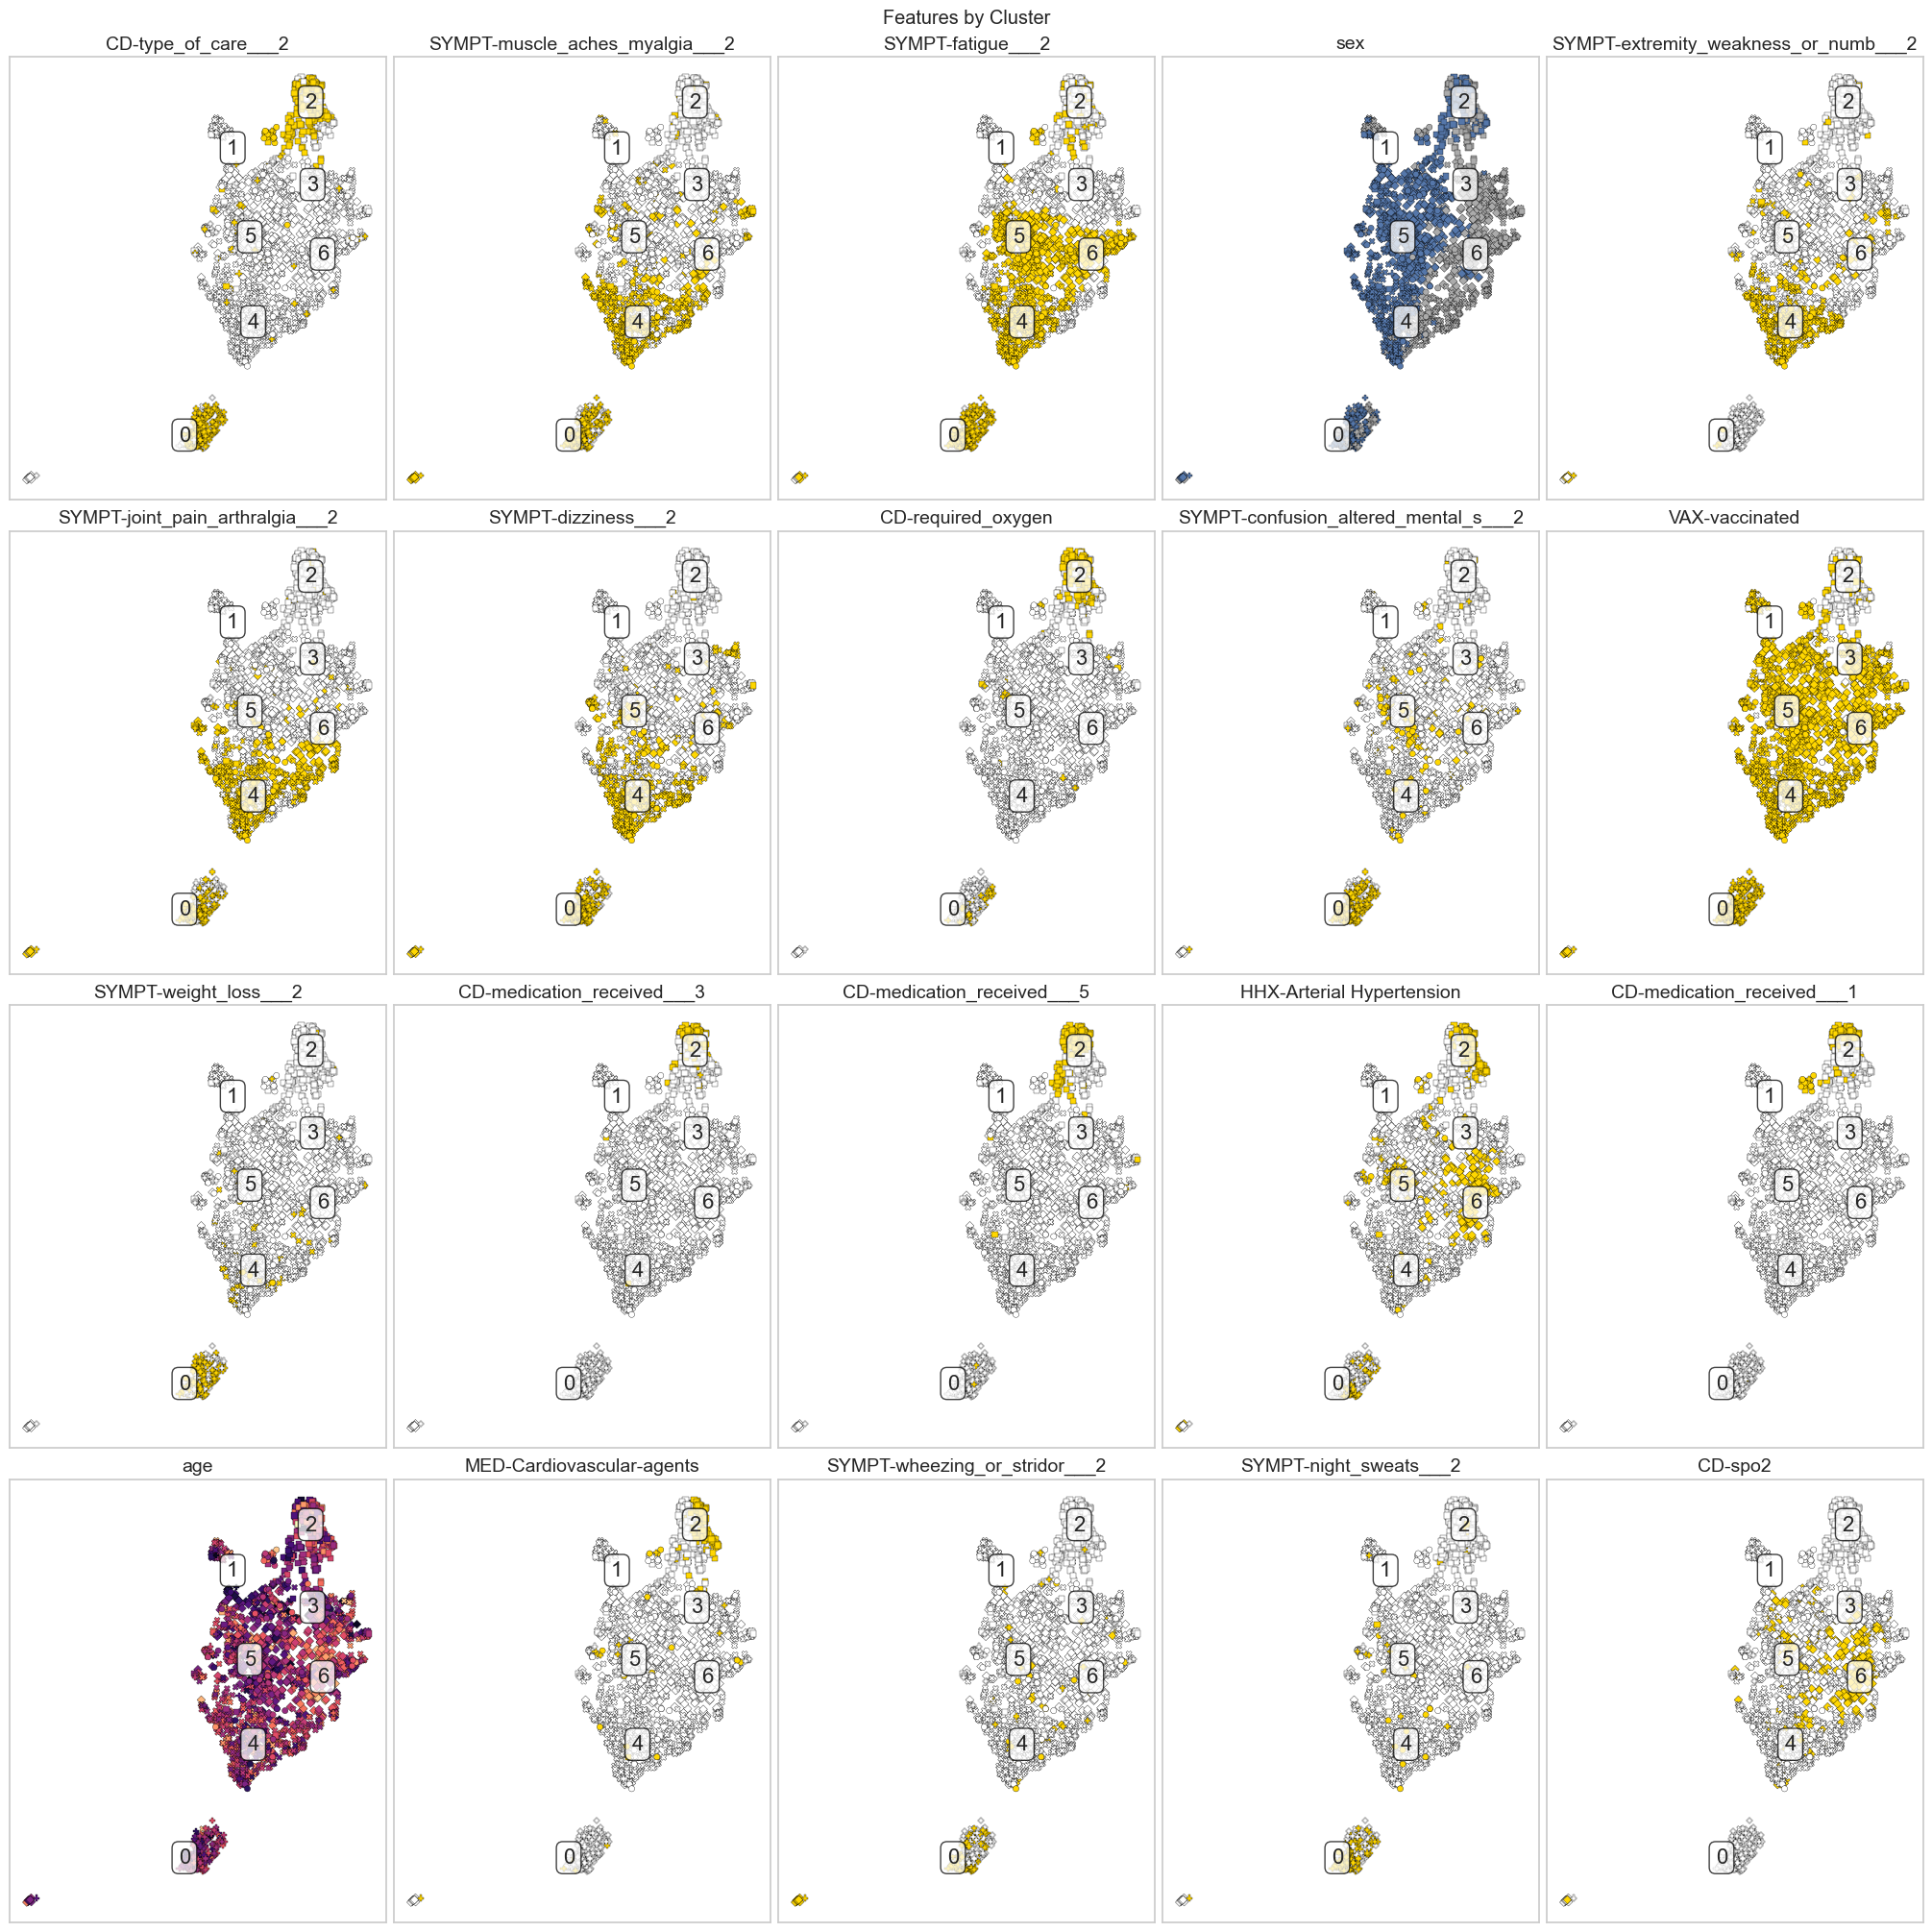

In [405]:
int_feat = dd["Feature"][:20]
# int_feat = features20["Feature"]

# make an array of 10 figures

fig3, ax = plt.subplots(4, 5, figsize=(20, 20), sharex = True, sharey = True, layout = "constrained")

ax  = ax.flatten()

centroids = make_centroids(plot_df[["x", "y"]].values, plot_df["Cluster"])

for i, f in enumerate(int_feat):


# for f in dd["Feature"][:5]:
# for f in ["Fatigue", "Dyspnea", "LABS-IND-creatinine"]:

    # fig,ax = plt.subplots(figsize=(6,6))

    if f == "age":
        plot_df[f] = X[f]
        palette = 'magma'
        # palette = cc.bwy[:2]
        hue_order = None

    elif f == "sex":
        plot_df[f] = X[f].map({0: "Male", 1:"Female"})
        palette = ["#ababab", "#5577aa"]
        hue_order = ["Male", "Female"]

    else:
        plot_df[f] = X[f].map(sympt_dict)
        palette = ['white', 'gold']
        hue_order = ["Absent", "Present"]


    sns.scatterplot(data = plot_df, 
                    x         = "x", 
                    y         = "y", 
                    # hue = "Dyspnea", 
                    # hue_order = ["None", "Onset", "Now", "Both"],
                    hue       = f,
                    palette   = palette, 
                    hue_order = hue_order,
                    # palette   = cc.glasbey_hv[:2], 
                    style     = "Site", 
                    style_order = site_name_dict.values(), 
                    markers   = ['o','D', 'P', 'X', 's'], 
                    edgecolor = 'k', 
                    linewidth = 0.25, 
                    s         = 20, 
                    # alpha     = 0.75,
                    ax        = ax[i]
                    )

    plot_centroids(centroids, ax[i], alpha = 0.75)

    # turn off the ticks on the ax
    ax[i].set_xticks([]); ax[i].set_yticks([])
    ax[i].set_xlabel(""); ax[i].set_ylabel("")

    # set axis title
    ax[i].set_title(f)

    # set title size smaller
    ax[i].title.set_size(14)

    # turn off the legnd on the ax
    ax[i].legend().remove()

    # set aspect ratio to 1
    # ax[i].set_aspect('equal')

    # turn off grid and ticks
    plt.xticks([]); plt.yticks([])
    plt.xlabel(""); plt.ylabel("")

    # turn off legend
    plt.legend().remove()

    # plt.title(f"{f} by Cluster")
    # plt.savefig(f"{figdir}/{f}.png", dpi = 300, bbox_inches = 'tight')


plt.suptitle("Features by Cluster")
plt.savefig(f"{figdir}/features-by-cluster.png", dpi = 300, bbox_inches = 'tight')

### Excursion Plots

In [345]:
# save the cluster labels to a copy of the original dataframe

A = X.copy()
A["cluster"] = cluster_labels


interesting = [
            #    "VAX-vaccinated", 
                "HHX-HIV or AIDS", 
               "HHX-Diabetes", 
               "HHX-Arterial Hypertension", 
               "HHX-Psychiatric disease", 
               ]


# try:
#     # get the means by cluster
#     print(A.groupby("cluster")[interesting].mean())
# except:
#     pass


In [346]:
# sort the columns in A by the order of Feature in dd

M = A.copy()
# M = A[dd["Feature"].values].copy()
M["cluster"] = cluster_labels

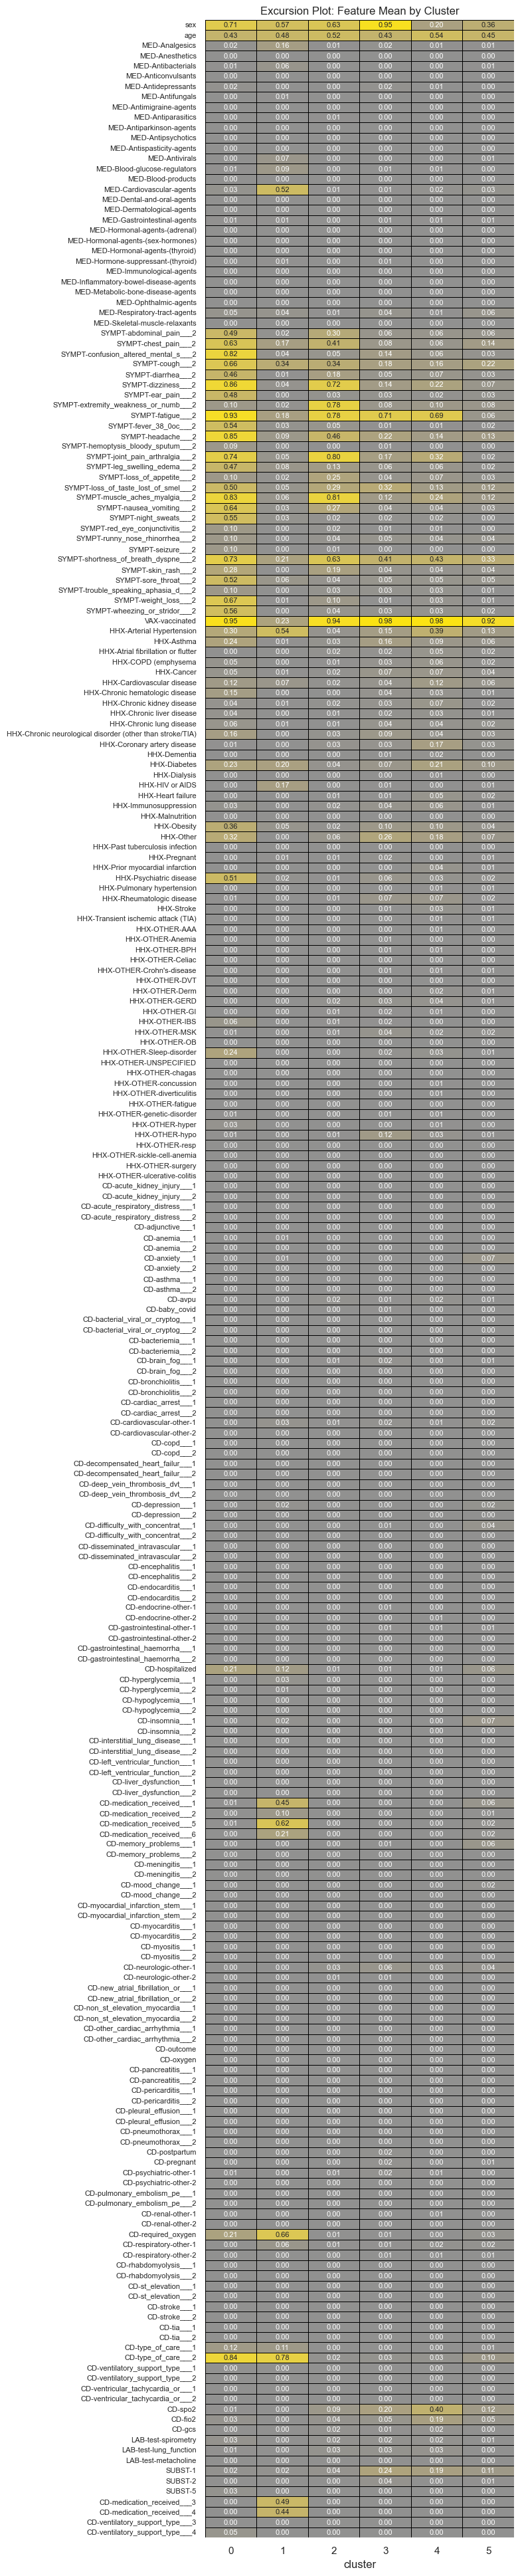

In [347]:
g, q = excursion_plot(M, method = "mean", style = "cont")

fn = f"mean-feature-values-umap-{tag}.png"
p = f"{figdir}/{fn}"

plt.savefig(p, dpi = 300, bbox_inches = 'tight')

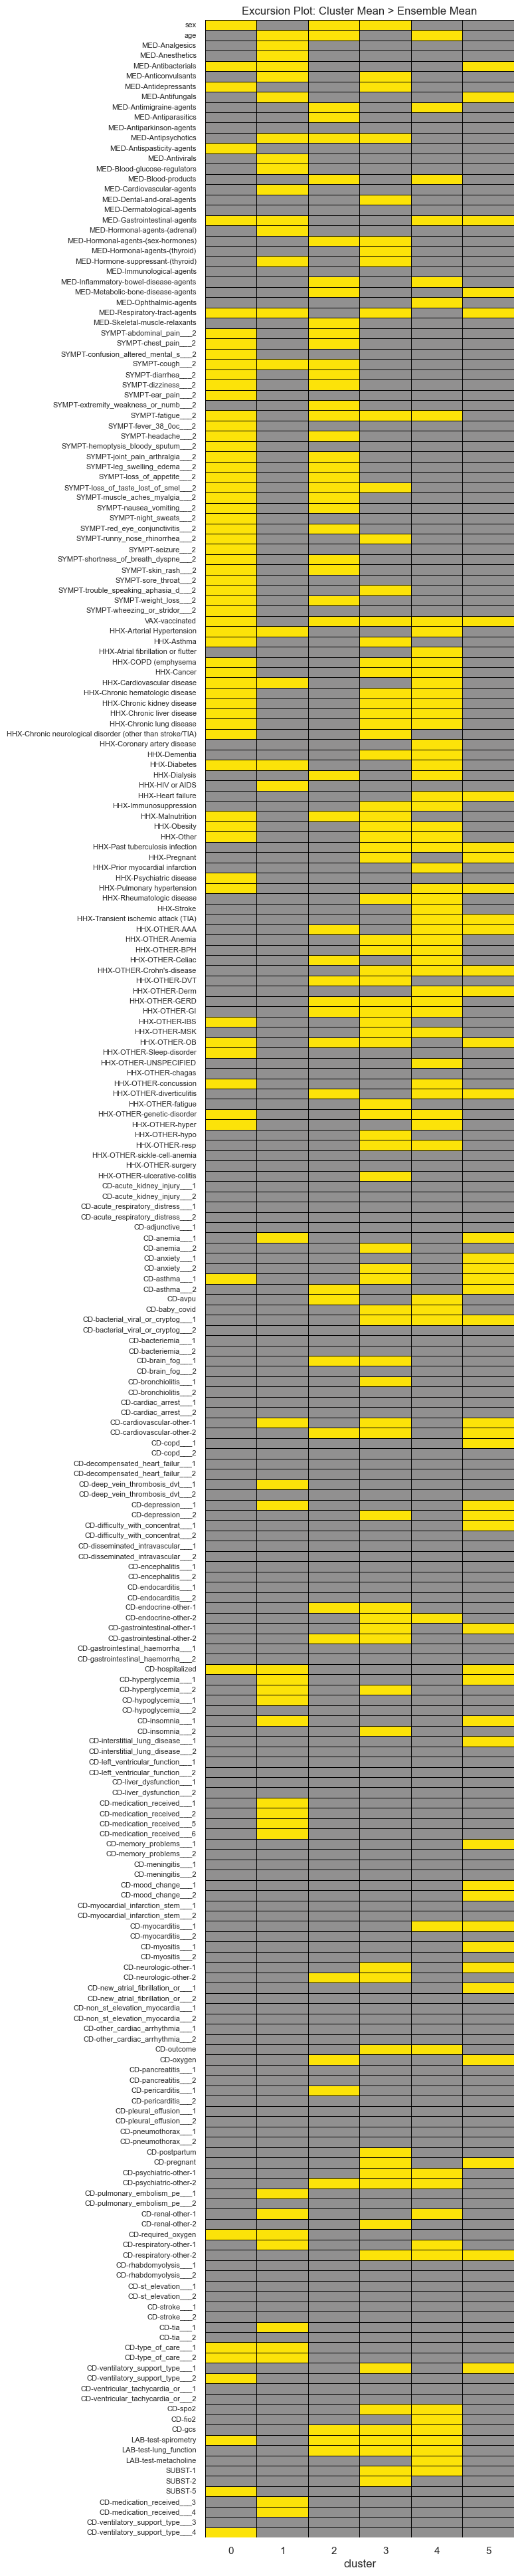

In [348]:
g,q = excursion_plot(M, method = "mean")


fn = f"binary-feature-values-umap-{tag}.png"
p = f"{figdir}/{fn}"

plt.savefig(p, dpi = 300, bbox_inches = 'tight')

### Compare some clusters

In [349]:
A["SITE"] = LC_pos_["SITE"]

In [350]:
# ab = compare_two_clusters(A, 4,5)

# ab.groupby("cluster")["SITE"].value_counts().unstack().fillna(0).astype(int)
# ab

# ab.groupby("cluster")["HHX-HIV or AIDS"].value_counts(normalize = False).unstack().fillna(0)
# pd.pivot_table(ab, index = ["cluster", "SITE"], values = "HHX-HIV or AIDS", aggfunc = "sum")
# ab.groupby(["cluster", "SITE"])[["HHX-HIV or AIDS", "VAX-vaccinated"]].value_counts().unstack()

# # interesting features
# interesting = [
#                # "VAX-vaccinated", 
#                 "HHX-HIV or AIDS", 
#                "HHX-Diabetes", 
#                "HHX-Arterial Hypertension", 
#                "HHX-Psychiatric disease", 
#             #    "age"
#                ]

# i2df = make_upset_data(ab, interesting)
# upset = UpSet(i2df, 
#                 subset_size = "count", 
#                 orientation = "horizontal", 
#                 show_counts = True, 
#                 intersection_plot_elements = 0
#                 )
# upset.add_stacked_bars(by="SITE", title="Count SITE", elements=5, colors = cc.m_glasbey_hv)
# # upset.add_stacked_bars(by="cluster", title="Count Cluster", elements=5, colors = cc.m_glasbey_hv)

# upset.plot()

### UPSET PLOTS

In [351]:
II = pd.DataFrame(scaler.inverse_transform(A.drop(["cluster", "SITE"], axis = 1))) # type: ignore

# get column names and index names from X 
II.columns = X.columns
II.index   = X.index

In [352]:
# A.shape, X.shape, II.shape
# vv = A.drop("cluster", axis = 1)
B = II.copy()

# augment with site labels
B["SITE"] = LC_pos_["SITE"].map(site_name_dict)

# expand the SITE column to five one-hot encoded columns
# B = pd.concat([B, pd.get_dummies(B["SITE"])], axis = 1)

In [353]:
# TODO: get the interesting features from the feature selection list above
# TODO: or sort everyting by feature importance, then make the full plots

In [354]:
interesting = list(g.index[:5])

In [355]:
interesting = list(fff["Feature"][:5])
interesting

['SYMPT-extremity_weakness_or_numb___2',
 'SYMPT-joint_pain_arthralgia___2',
 'sex',
 'SYMPT-dizziness___2',
 'SYMPT-fatigue___2']

In [356]:
upset_A = make_upset_data(A, 
                       interesting, 
                       )

In [357]:
upset_data = make_upset_data(B, 
                                interesting, 
                                keep_features = True
                                )

indicators_bool = upset_data.select_dtypes(include = ['bool'])

/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

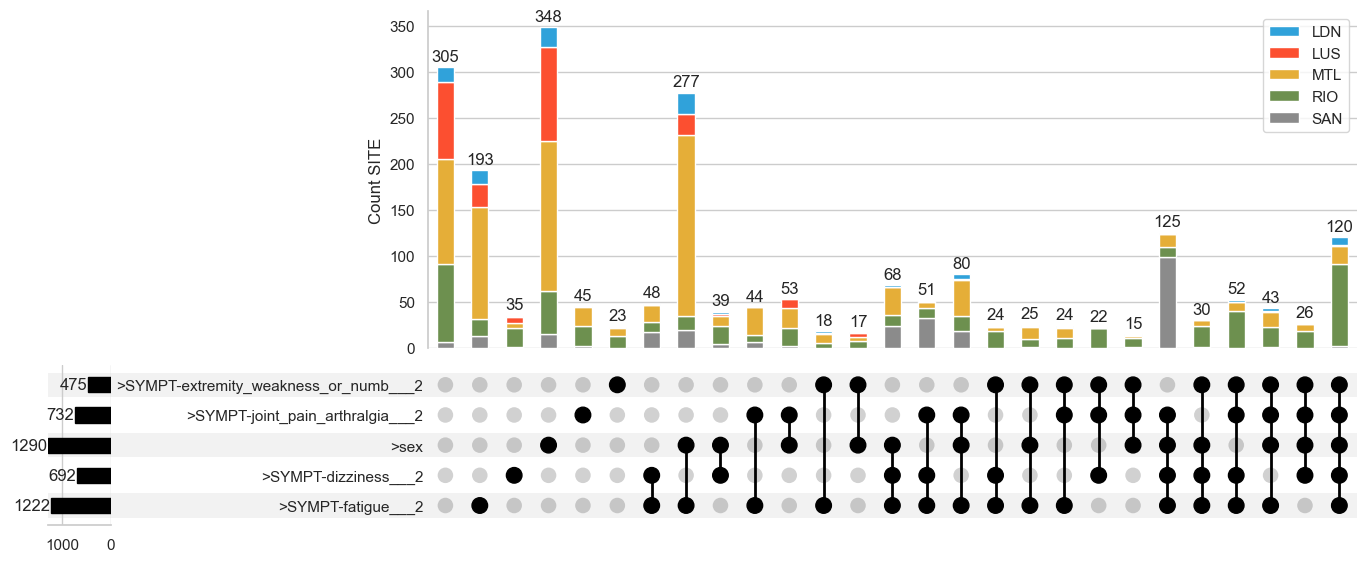

In [358]:
us = UpSet(
    from_indicators(indicators_bool, data = upset_data),
    min_subset_size=15,
    # max_subset_size=200,
    show_counts                = True,
    sort_categories_by         = "-input",
    subset_size                = "count",
    intersection_plot_elements = 0,
    orientation                = "horizontal",
)

# us.add_stacked_bars(by="SITE", title="Count SITE", elements=5, colors = cc.m_glasbey_hv)

# TODO: if using catplots, make sure we invert the scaling transformation

# us.add_catplot(value = "LABS-haemoglobin", kind = "strip",elements=5, edgecolor='w', linewidth = 0.5, s = 5, alpha = 0.5, vmin = -100)
# us.add_catplot(value = "LABS-haemoglobin", kind = "box",elements=5)


# us.style_subsets(present = ">HHX-HIV or AIDS",  edgecolor = cc.glasbey_light[0],  linewidth = 3, )

us.add_stacked_bars(by="SITE", 
                       title="Count SITE", 
                       elements=10, 
                       colors = cc.m_glasbey_hv, 
                       )


us.plot()
plt.show()

In [359]:
# upset = UpSet(upset_A, 
#                 subset_size = "count", 
#                 orientation = "horizontal", 
#                 sort_categories_by         = "-input",
#                 show_counts = False, 
#                 intersection_plot_elements = 0,
#                 max_subset_size = 200
#                 )
# # upset.style_subsets(present = ">HHX-HIV or AIDS",  edgecolor = "red", linewidth = 3)
# # upset.style_categories(">HHX-HIV or AIDS", shading_facecolor = "blue")

# # upset.add_stacked_bars(by="cluster", title="Count Cluster", elements=5, colors = cc.m_glasbey_hv)


# upset.plot()
# plt.show()

# SUBGROUP: Lusaka

In [360]:
# # make a df just for Lusaka
# df_lusaka = LC_pos.query('SITE == 5').copy()


# # drop object columns
# # drop columns with dtype = object
# try:
#     df_lusaka = df_lusaka.drop(columns=['LC_STATUS'])

# except:
#     pass

# df_lusaka.info()

# # fill nas with zero
# # df_lusaka.fillna(0, inplace = True)
# df_lusaka.dropna(inplace = True, axis = 1)

# # drop SITE and dag
# d1 = df_lusaka.drop(columns = ['SITE'])

In [361]:
# # sklearn pipelines
# import sklearn.cluster as cluster
# from sklearn.pipeline import Pipeline

# # instantiate the pipeline
# hdb_parms['min_cluster_size'] = int(np.sqrt(d1.shape[0]))

# pipe = Pipeline([
#                 ('scale', MinMaxScaler()),
#                 ('embed', UMAP(**umap_parms, verbose = True)),
#                 # ('embed', tsne_transformer),
#                 # ('cluster', cluster.HDBSCAN(min_cluster_size = min_cluster_size)),
#                 ('cluster', HDBSCAN(prediction_data = True)),

#                 ])

# # apply to the lusaka dataframe
# pipe.fit(d1)

# # check the version of the embed object

# if isinstance(pipe.steps[1][1], UMAP):
#     points   = pipe["embed"].embedding_
# elif isinstance(pipe.steps[1][1], FunctionTransformer):
#     points   = pipe["embed"].transform(d1)
# else:
#     print(f"Something went wrong - {pipe.steps[1][1]}")

# clusters = pipe["cluster"].labels_
# probs    = pipe["cluster"].probabilities_
# sites    = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)

# # # cluster labels are the maximally probable cluster
# cluster_labels = np.argmax(all_points_membership_vectors(pipe["cluster"]), 
#                            axis = 1)

# clusters = cluster_labels

# # plot it
# # sns.scatterplot(x = points[:,0], y = points[:,1], hue = clusters, palette = palette_dict, size = list(probs*100), linewidth = 0.5, edgecolor = 'black')

In [362]:
# d1.shape, df_lusaka.shape
# len(points)
# plot_df = pd.DataFrame(points, columns = ["x", "y"], index = df_lusaka.index)
# plot_df["Cluster"] = clusters
# plot_df["Cluster Confidence"] = probs
# plot_df["Site"] = df_lusaka["SITE"].map(site_name_dict)

# # what fraction of the data is in each cluster?
# plot_df["Cluster"].value_counts(normalize = True)*100

# plot_clusters(plot_df, site_name_dict, title = f"UMAP + HDBSCAN Clustering - Lusaka")
# # use a random forest classifier to find the most important features
# from sklearn.ensemble import RandomForestClassifier

# # instantiate the classifier
# rf = RandomForestClassifier(n_estimators = 1_000, max_depth = 5, random_state = 42)

# X = df_lusaka

# # fit the classifier

# rf.fit(X, cluster_labels)
# # get the 10 most important features
# importances = rf.feature_importances_

# indices = np.argsort(importances)[::-1][:10]

# # get the feature names
# features = X.columns

# # plot the feature importances
# plt.figure(figsize=(10, 6))

# plt.title("Feature importances")

# sns.barplot(x = importances[indices], y = features[indices], palette = "viridis")